### Датасет: Цены на акции
https://www.kaggle.com/datasets/nancyalaswad90/yamana-gold-inc-stock-Volume
##### О наборе данных: 
Yamana Gold Inc. — это канадская компания, которая занимается разработкой и управлением золотыми, серебряными и медными рудниками, расположенными в Канаде, Чили, Бразилии и Аргентине. Головной офис компании находится в Торонто.

Yamana Gold была основана в 1994 году и уже через год была зарегистрирована на фондовой бирже Торонто. В 2007 году она стала участником Нью-Йоркской фондовой биржи, а в 2020 году — Лондонской.
В 2003 году компания претерпела значительные изменения: была проведена реструктуризация, в результате которой Питер Марроне занял пост главного исполнительного директора. Кроме того, Yamana объединилась с бразильской компанией Santa Elina Mines Corporation. Благодаря этому слиянию Yamana получила доступ к капиталу, накопленному Santa Elina, что позволило ей начать разработку и эксплуатацию рудника Чапада. Затем компания объединилась с другими организациями, зарегистрированными на бирже TSX: RNC Gold, Desert Sun Mining, Viceroy Exploration, Northern Orion Resources, Meridian Gold, Osisko Mining и Extorre Gold Mines. Каждая из них внесла свой вклад в разработку месторождения или проект, который в итоге был успешно запущен.
##### Таким образом:
* Объект наблюдения - цены и объемы акций компании
* Атрибуты: 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'

##### Бизнес цели:
*  Прогнозирование будущей цены акций.(Цены закрытия)
        Использование данных для создания модели, которая будет предсказывать цену акций компании в будущем. Целевая переменная: Цена закрытия (Close)
*  Определение волатильности акций.
        Определение, колебаний цен акций, что поможет инвесторам понять риски. Прогнозировать волатильность акций на основе изменений в ценах открытий, максимума, минимума и объема торгов. Целевая переменная: Разница между высокой и низкой ценой (High - Low). (среднее значение)

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

df = pd.read_csv(".//static//csv//Stocks.csv", sep=",")
print('Количество колонок: ' + str(df.columns.size))  
print('Колонки: ' + ', '.join(df.columns)+'\n')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


df.info()
df.tail()

Количество колонок: 7
Колонки: Date, Open, High, Low, Close, Adj Close, Volume

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5251 entries, 0 to 5250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5251 non-null   datetime64[ns]
 1   Open       5251 non-null   float64       
 2   High       5251 non-null   float64       
 3   Low        5251 non-null   float64       
 4   Close      5251 non-null   float64       
 5   Adj Close  5251 non-null   float64       
 6   Volume     5251 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 287.3 KB


Date  Open  High   Low  Close  Adj Close    Volume
5246 2022-04-29  5.66  5.69  5.50   5.51       5.51  16613300
5247 2022-05-02  5.33  5.39  5.18   5.30       5.30  27106700
5248 2022-05-03  5.32  5.53  5.32   5.47       5.47  18914200
5249 2022-05-04  5.47  5.61  5.37   5.60       5.60  20530700
5250 2022-05-05  5.63  5.66  5.34   5.44       5.44  19879200

### Подготовка данных:

#### 1. Получение сведений о пропущенных данных
Типы пропущенных данных:

- None - представление пустых данных в Python
- NaN - представление пустых данных в Pandas
- '' - пустая строка

In [90]:
# Количество пустых значений признаков
print(df.isnull().sum())
print()

# Есть ли пустые значения признаков
print(df.isnull().any())
print()

# Проверка на бесконечные значения
print("Количество бесконечных значений в каждом столбце:")
print(np.isinf(df).sum())

# Процент пустых значений признаков
for i in df.columns:
    null_rate = df[i].isnull().sum() / len(df) * 100
    print(f"{i} процент пустых значений: %{null_rate:.2f}")

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

Количество бесконечных значений в каждом столбце:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date процент пустых значений: %0.00
Open процент пустых значений: %0.00
High процент пустых значений: %0.00
Low процент пустых значений: %0.00
Close процент пустых значений: %0.00
Adj Close процент пустых значений: %0.00
Volume процент пустых значений: %0.00


Таким образом, пропущенных значений не найдено.

#### 2. Проверка выбросов данных и устранение их при наличии:

In [91]:
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

for column in numeric_columns:
    if pd.api.types.is_numeric_dtype(df[column]):  # Проверяем, является ли колонка числовой
        q1 = df[column].quantile(0.25)  # Находим 1-й квартиль (Q1)
        q3 = df[column].quantile(0.75)  # Находим 3-й квартиль (Q3)
        iqr = q3 - q1  # Вычисляем межквартильный размах (IQR)

        # Определяем границы для выбросов
        lower_bound = q1 - 1.5 * iqr  # Нижняя граница
        upper_bound = q3 + 1.5 * iqr  # Верхняя граница

        # Подсчитываем количество выбросов
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = outliers.shape[0]

        print("До устранения выбросов:")
        print(f"Колонка {column}:")
        print(f"  Есть выбросы: {'Да' if outlier_count > 0 else 'Нет'}")
        print(f"  Количество выбросов: {outlier_count}")
        print(f"  Минимальное значение: {df[column].min()}")
        print(f"  Максимальное значение: {df[column].max()}")
        print(f"  1-й квартиль (Q1): {q1}")
        print(f"  3-й квартиль (Q3): {q3}\n")

        # Устраняем выбросы: заменяем значения ниже нижней границы на саму нижнюю границу, а выше верхней — на верхнюю
        if outlier_count != 0:
            df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
        
        # Подсчитываем количество выбросов
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = outliers.shape[0]

        print("После устранения выбросов:")
        print(f"Колонка {column}:")
        print(f"  Есть выбросы: {'Да' if outlier_count > 0 else 'Нет'}")
        print(f"  Количество выбросов: {outlier_count}")
        print(f"  Минимальное значение: {df[column].min()}")
        print(f"  Максимальное значение: {df[column].max()}")
        print(f"  1-й квартиль (Q1): {q1}")
        print(f"  3-й квартиль (Q3): {q3}\n")


До устранения выбросов:
Колонка Open:
  Есть выбросы: Нет
  Количество выбросов: 0
  Минимальное значение: 1.142857
  Максимальное значение: 20.42
  1-й квартиль (Q1): 2.857143
  3-й квартиль (Q3): 10.65

После устранения выбросов:
Колонка Open:
  Есть выбросы: Нет
  Количество выбросов: 0
  Минимальное значение: 1.142857
  Максимальное значение: 20.42
  1-й квартиль (Q1): 2.857143
  3-й квартиль (Q3): 10.65

До устранения выбросов:
Колонка High:
  Есть выбросы: Нет
  Количество выбросов: 0
  Минимальное значение: 1.142857
  Максимальное значение: 20.59
  1-й квартиль (Q1): 2.88
  3-й квартиль (Q3): 10.86

После устранения выбросов:
Колонка High:
  Есть выбросы: Нет
  Количество выбросов: 0
  Минимальное значение: 1.142857
  Максимальное значение: 20.59
  1-й квартиль (Q1): 2.88
  3-й квартиль (Q3): 10.86

До устранения выбросов:
Колонка Low:
  Есть выбросы: Нет
  Количество выбросов: 0
  Минимальное значение: 1.142857
  Максимальное значение: 20.09
  1-й квартиль (Q1): 2.81
  3-й квар

Выбросы присутствовали, но мы их устранили.

### Разбиение на выборки:

Разобьем наш набор на обучающую, контрольную и тестовую выборки для устранения проблемы просачивания данных.
Разделим на два варианта - набор для первой бизнес цели - его будем применять для решения задаи регрессии. И набор для второй бизнес цели - его используем для решения задач классификации.

In [92]:
from typing import Tuple
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

df['Volatility'] = (df['High'] - df['Low']) / df['Close']

def split_into_train_test(
    df_input: DataFrame,
    target_colname: str = "Volatility",
    frac_train: float = 0.8,
    random_state: int = None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame]:
    
    if not (0 < frac_train < 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    # Проверка наличия целевого признака
    if target_colname not in df_input.columns:
        raise ValueError(f"{target_colname} is not a column in the DataFrame.")
    
    # Разделяем данные на признаки и целевую переменную
    X = df_input.drop(columns=[target_colname])  # Признаки
    y = df_input[[target_colname]]  # Целевая переменная

    # Удаляем указанные столбцы из X
    columns_to_remove = ["Date", "Adj Close", "Volatility"]
    X = X.drop(columns=columns_to_remove, errors='ignore')  # Игнорировать ошибку, если столбцы не найдены

    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=(1.0 - frac_train),
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# Применение функции для разделения данных
X_train, X_test, y_train, y_test = split_into_train_test(
    df, 
    target_colname="Volatility", 
    frac_train=0.8, 
    random_state=42
)

# Для отображения результатов
display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

Open   High    Low      Close      Volume
4789   5.66   5.73   5.47   5.560000  23355100.0
3469   3.86   3.93   3.81   3.880000   7605300.0
2503  12.19  12.28  11.95  12.020000   7243200.0
1580  11.77  11.84  11.53  11.570000   3025900.0
2759  15.77  16.17  15.76  16.120001   6113400.0
...     ...    ...    ...        ...         ...
3092   9.57   9.87   9.30   9.750000   7283100.0
3772   4.76   4.97   4.67   4.930000  12920800.0
5191   4.18   4.29   4.17   4.200000  11192400.0
5226   5.58   5.68   5.55   5.580000  12692800.0
860    3.18   3.19   3.13   3.180000     99100.0

[4200 rows x 5 columns]

'y_train'

Volatility
4789    0.046763
3469    0.030928
2503    0.027454
1580    0.026793
2759    0.025434
...          ...
3092    0.058462
3772    0.060852
5191    0.028571
5226    0.023297
860     0.018868

[4200 rows x 1 columns]

'X_test'

Open       High        Low      Close      Volume
1437  13.710000  14.000000  13.670000  13.940000   7623200.0
2700  15.520000  15.720000  15.300000  15.320000   6098800.0
3647   1.870000   1.930000   1.830000   1.830000  10980000.0
2512  11.260000  11.470000  11.260000  11.320000   5029300.0
2902  16.379999  16.580000  16.250000  16.549999   5485800.0
...         ...        ...        ...        ...         ...
3095   9.290000   9.350000   9.070000   9.130000   5861400.0
859    3.090000   3.160000   3.040000   3.100000    211300.0
3134   8.550000   8.770000   8.550000   8.770000   5335400.0
2577  16.709999  17.070000  16.379999  16.400000  14524400.0
378    2.571429   2.571429   2.571429   2.571429         0.0

[1051 rows x 5 columns]

'y_test'

Volatility
1437    0.023673
2700    0.027415
3647    0.054645
2512    0.018551
2902    0.019940
...          ...
3095    0.030668
859     0.038710
3134    0.025086
2577    0.042073
378     0.000000

[1051 rows x 1 columns]

In [93]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from typing import Tuple
from pandas import DataFrame

def split_into_train_close_test(
    df_input: DataFrame,
    target_colname: str = "Close",
    frac_train: float = 0.8,
    random_state: int = None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame]:
    
    if not (0 < frac_train < 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    # Проверка наличия целевого признака
    if target_colname not in df_input.columns:
        raise ValueError(f"{target_colname} is not a column in the DataFrame.")
    
    # Разделяем данные на признаки и целевую переменную
    X = df_input.drop(columns=[target_colname])  # Признаки
    
    # Преобразование целевой переменной в категориальную
    bins = [-np.inf, 10, np.inf]
    labels = ['low', 'high']
    y = pd.cut(df_input[target_colname], bins=bins, labels=labels)  # Целевая переменная
    
    # Преобразование целевой переменной в числовые значения
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)  # Интеграция, чтобы вернуть числовые метки
    
    # Удаляем указанные столбцы из X
    columns_to_remove = ["Date", "Adj Close", "Close"]
    X = X.drop(columns=columns_to_remove, errors='ignore')  # Игнорировать ошибку, если столбцы не найдены

    # Разделяем данные на обучающую и тестовую выборки
    X_train_close, X_test_close, y_train_close, y_test_close = train_test_split(
        X, y_encoded,
        test_size=(1.0 - frac_train),
        random_state=random_state
    )
    
    # Конвертируем y_train_close и y_test_close в DataFrame
    y_train_close = pd.DataFrame(y_train_close, columns=[target_colname])
    y_test_close = pd.DataFrame(y_test_close, columns=[target_colname])

    return X_train_close, X_test_close, y_train_close, y_test_close

# Применение функции для разделения данных
X_train_close, X_test_close, y_train_close, y_test_close = split_into_train_close_test(
    df, 
    target_colname="Close", 
    frac_train=0.8, 
    random_state=42
)

# Для отображения результатов
display(X_train_close)
display(y_train_close)
display(X_test_close)
display(y_test_close)

Open   High    Low      Volume  Volatility
4789   5.66   5.73   5.47  23355100.0    0.046763
3469   3.86   3.93   3.81   7605300.0    0.030928
2503  12.19  12.28  11.95   7243200.0    0.027454
1580  11.77  11.84  11.53   3025900.0    0.026793
2759  15.77  16.17  15.76   6113400.0    0.025434
...     ...    ...    ...         ...         ...
3092   9.57   9.87   9.30   7283100.0    0.058462
3772   4.76   4.97   4.67  12920800.0    0.060852
5191   4.18   4.29   4.17  11192400.0    0.028571
5226   5.58   5.68   5.55  12692800.0    0.023297
860    3.18   3.19   3.13     99100.0    0.018868

[4200 rows x 5 columns]

Close
0         1
1         1
2         0
3         0
4         0
...     ...
4195      1
4196      1
4197      1
4198      1
4199      1

[4200 rows x 1 columns]

Open       High        Low      Volume  Volatility
1437  13.710000  14.000000  13.670000   7623200.0    0.023673
2700  15.520000  15.720000  15.300000   6098800.0    0.027415
3647   1.870000   1.930000   1.830000  10980000.0    0.054645
2512  11.260000  11.470000  11.260000   5029300.0    0.018551
2902  16.379999  16.580000  16.250000   5485800.0    0.019940
...         ...        ...        ...         ...         ...
3095   9.290000   9.350000   9.070000   5861400.0    0.030668
859    3.090000   3.160000   3.040000    211300.0    0.038710
3134   8.550000   8.770000   8.550000   5335400.0    0.025086
2577  16.709999  17.070000  16.379999  14524400.0    0.042073
378    2.571429   2.571429   2.571429         0.0    0.000000

[1051 rows x 5 columns]

Close
0         0
1         0
2         1
3         0
4         0
...     ...
1046      1
1047      1
1048      1
1049      0
1050      1

[1051 rows x 1 columns]

##### Определение достижимого уровня качества модели

In [94]:
# Оценка базовых моделей (можно использовать, например, линейную регрессию как базу)
from sklearn.linear_model import LinearRegression


baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
baseline = baseline_model.predict(X_test)

# Оценка качества
print(f'Baseline Volatility MSE: {mean_squared_error(y_test, baseline)}')
print(f'Baseline Volatility R^2: {r2_score(y_test, baseline)}')

baseline_model_close = LinearRegression()
baseline_model_close.fit(X_train_close, y_train_close)
baseline_close = baseline_model_close.predict(X_test_close)

print(f'Baseline Close MSE: {mean_squared_error(y_test_close, baseline_close)}')
print(f'Baseline Close R^2: {r2_score(y_test_close, baseline_close)}')

Baseline Volatility MSE: 0.0002712979238081643
Baseline Volatility R^2: 0.6636185388238924
Baseline Close MSE: 0.04753452157168089
Baseline Close R^2: 0.764076420247305


**Цена:**
- MSE: 0.0475— Этот показатель говорит о том, что в среднем модель делает небольшую ошибку в предсказании цен.
- R²: 0.6636 — Это значение указывает на то, что модель объясняет только около 66% вариации волатильности.

**Волатильность:**
- MSE: 0.00027183 — Как и в случае с ценами, это значение может показаться малым, однако из-за низкого значения волатильности в финансовых данных даже небольшие ошибки могут иметь значение.
- R²: 0.6629 — Это значение указывает на то, что модель объясняет только около 66% вариации волатильности.

### **Создадим конвейер:**
##### Конвейеры позволяют автоматизировать следующие процессы:
1. Предобработка данных.
2. Конструирование признаков.
3. Понижение размерности признакового пространства.
4. Обучение модели.


##### Используемые конвейеры:
1. preprocessing_num -- конвейер для обработки числовых данных: заполнение пропущенных значений и стандартизация

2. preprocessing_cat -- конвейер для обработки категориальных данных: заполнение пропущенных данных и унитарное кодирование

3. features_preprocessing -- трансформер для предобработки признаков

4. features_engineering -- трансформер для конструирования признаков

5. drop_columns -- трансформер для удаления колонок

6. pipeline_end -- основной конвейер предобработки данных и конструирования признаков

In [95]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor  # Пример регрессионной модели
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

class StocksFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X["Range"] = X["High"] - X["Low"]
        return X

    def get_feature_names_out(self, features_in):
        return np.append(features_in, ["Range"], axis=0)

num_columns = ["Open", "High", "Low", "Close", "Volume"]

# Определяем предобработку для численных данных
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# У категориальных данных нет, оставляем пустым
cat_columns = []

# Подготовка признаков с использованием ColumnTransformer
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
    ],
    remainder="passthrough"
)

# Выделим целевую переменную
y_train = y_train.values.reshape(-1, 1)  # Убедимся, что y_train - это 2D массив

# Создание окончательного конвейера
pipeline = Pipeline(steps=[
    ('feature_engineering', StocksFeatures()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]
)

Применим конвейер


In [96]:
# Применяем конвейер к X_train
preprocessing_result = pipeline.fit_transform(X_train)

# Формируем новый датафрейм с обработанными данными
preprocessed_df = pd.DataFrame(
    preprocessing_result, 
    columns=pipeline.get_feature_names_out(input_features=num_columns),
)

# Выводим обработанный датафрейм
print(preprocessed_df)

          Open      High       Low     Close    Volume     Range
0    -0.264188 -0.270892 -0.278887 -0.282602  1.986714 -0.037298
1    -0.642218 -0.642866 -0.634425 -0.636104 -0.197546 -0.634720
2     1.107219  1.082683  1.108998  1.076697 -0.247763  0.261413
3     1.019012  0.991756  1.019043  0.982009 -0.832639  0.176067
4     1.859078  1.886561  1.925023  1.939410 -0.404450  0.602796
...        ...       ...       ...       ...       ...       ...
4195  0.556976  0.584650  0.541422  0.599049 -0.242230  1.285564
4196 -0.453203 -0.427948 -0.450230 -0.415165  0.539634  0.133394
4197 -0.575013 -0.568471 -0.557320 -0.568770  0.299931 -0.634720
4198 -0.280990 -0.281224 -0.261752 -0.278393  0.508014 -0.592047
4199 -0.785029 -0.795789 -0.780067 -0.783396 -1.238542 -0.890757

[4200 rows x 6 columns]


### **Для начала разберемся с задачей регрессии:**


Обучение сводится к минимизации средней ошибки отклонения полученного
целевого признака от реального значения целевого признака для всей выборки.

Регрессия (аппроксимация).
Получение значения из области значений целевого признака.

Выберем регрессонные модели, а именно:
1. Рандомный лес
2. Гребневая регрессия
3. Градиентный бустинг

Настроим гиперпараметры для каждой модели.

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import pandas as pd

# 1. Настройка гиперпараметров для каждой модели
# Random Forest hyperparameters
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20],
}

# Ridge hyperparameters
ridge_params = {
    'alpha': [0.1, 1.0, 10.0],
}

# Gradient Boosting hyperparameters
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
}

# Curate a function for model training and evaluation
def train_and_evaluate_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Исходные данные после преобразования (Pipeline применения)
X_train_transformed = pipeline.fit_transform(X_train)

# Обучение моделей с подбором гиперпараметров
rf_model, rf_params = train_and_evaluate_model(RandomForestRegressor(), rf_params, X_train_transformed, y_train)
ridge_model, ridge_params = train_and_evaluate_model(Ridge(), ridge_params, X_train_transformed, y_train)
gb_model, gb_params = train_and_evaluate_model(GradientBoostingRegressor(), gb_params, X_train_transformed, y_train)

c:\Users\K\source\repos\AIM-PIbd-31-Ievlewa-M-D\aimenv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\K\source\repos\AIM-PIbd-31-Ievlewa-M-D\aimenv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\K\source\repos\AIM-PIbd-31-Ievlewa-M-D\aimenv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\K\source\repos\AIM-PIbd-31-Ievlewa-M-D\aimenv\Lib\site-packages\sklearn\base.py:1473: DataConvers

#### Обучим модели на преобразованных данных:

In [98]:
# Обучение с использованием лучших моделей
rf_model.fit(X_train_transformed, y_train)
ridge_model.fit(X_train_transformed, y_train)
gb_model.fit(X_train_transformed, y_train)

c:\Users\K\source\repos\AIM-PIbd-31-Ievlewa-M-D\aimenv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\K\source\repos\AIM-PIbd-31-Ievlewa-M-D\aimenv\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(max_depth=5)

#### Оценка моделей:

In [99]:
# Оценка качества и получение предсказаний для тестового набора
X_test_transformed = pipeline.transform(X_test)

models = [rf_model, ridge_model, gb_model]
model_names = ['Random Forest', 'Ridge', 'Gradient Boosting']

results = []
for model, name in zip(models, model_names):
    predictions = model.predict(X_test_transformed)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    })

results_df = pd.DataFrame(results)
print(results_df)

# Определение наилучшей модели по метрике R²
best_model_info = results_df.loc[results_df['R2'].idxmax()]
best_model_name = best_model_info['Model']
best_model = models[results_df['R2'].idxmax()]

print(f'Лучшая модель: {best_model_name}')

               Model       MAE       MSE        R2
0      Random Forest  0.001764  0.000026  0.967882
1              Ridge  0.010975  0.000271  0.663739
2  Gradient Boosting  0.000987  0.000004  0.995060
Лучшая модель: Gradient Boosting


#### Оценим смещение и дисперсию для модели с лучшей оценкой:

Bias: 0.0014630506389881025, Variance: 0.0006564383445844139


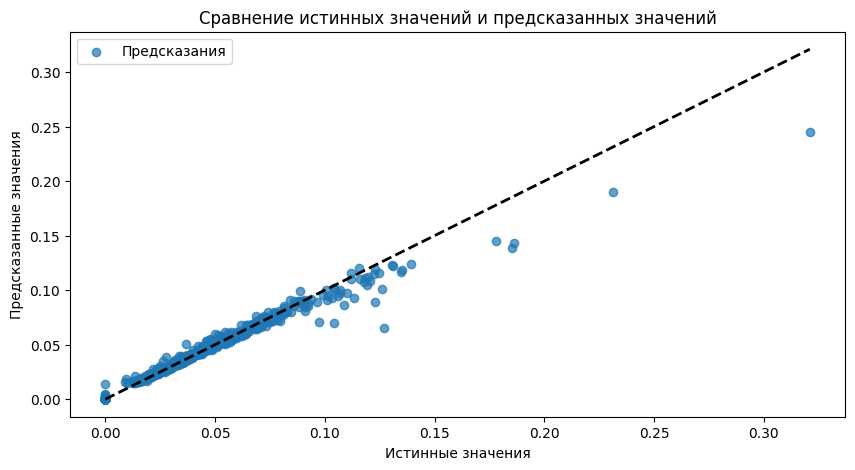

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для оценки смещения и дисперсии
def plot_bias_variance(model, X_train, y_train, X_test, y_test):
    # Предсказания на обучающей и тестовой выборках
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Оценка смещения
    bias = np.mean((test_preds - y_test.to_numpy()) ** 2)
    variance = np.var(test_preds)

    print(f'Bias: {bias}, Variance: {variance}')

    # Визуализация предсказаний
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test.to_numpy(), test_preds, label='Предсказания', alpha=0.7)
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.title('Сравнение истинных значений и предсказанных значений')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.legend()
    plt.show()

# Пример использования
plot_bias_variance(rf_model, X_train_transformed, y_train, X_test_transformed, y_test)

#### **Таким образом в задачах регрессии в качестве оценок используются следующие метрики:**
1. **Средняя квадратичная ошибка (англ. Mean Squared Error, MSE)**
MSE применяется в ситуациях, когда нам надо подчеркнуть большие ошибки и выбрать модель, которая дает меньше больших ошибок прогноза. Грубые ошибки становятся заметнее за счет того, что ошибку прогноза мы возводим в квадрат. И модель, которая дает нам меньшее значение среднеквадратической ошибки, можно сказать, что что у этой модели меньше грубых ошибок.

2. **Cредняя абсолютная ошибка (англ. Mean Absolute Error, MAE)**
Среднеквадратичный функционал сильнее штрафует за большие отклонения по сравнению со среднеабсолютным, и поэтому более чувствителен к выбросам. При использовании любого из этих двух функционалов может быть полезно проанализировать, какие объекты вносят наибольший вклад в общую ошибку — не исключено, что на этих объектах была допущена ошибка при вычислении признаков или целевой величины.
Среднеквадратичная ошибка подходит для сравнения двух моделей или для контроля качества во время обучения, но не позволяет сделать выводов о том, на сколько хорошо данная модель решает задачу. Например, MSE = 10 является очень плохим показателем, если целевая переменная принимает значения от 0 до 1, и очень хорошим, если целевая переменная лежит в интервале (10000, 100000). В таких ситуациях вместо среднеквадратичной ошибки полезно использовать коэффициент детерминации — R2

3. **Коэффициент детерминации**
Коэффициент детерминации измеряет долю дисперсии, объясненную моделью, в общей дисперсии целевой переменной. Фактически, данная мера качества — это нормированная среднеквадратичная ошибка. Если она близка к единице, то модель хорошо объясняет данные, если же она близка к нулю, то прогнозы сопоставимы по качеству с константным предсказанием.

#### **Анализ Метрик:**
1. Random Forest:
* MAE: 0.001779
* MSE: 0.000027
* R²: 0.966258

Random Forest демонстрирует хорошую производительность с высоким R², что указывает на то, что модель способна объяснить примерно 96.6% изменчивости в данных. Низкие значения MAE и MSE свидетельствуют о том, что предсказания модели близки к истинным значениям.

2. Ridge:
* MAE: 0.010975
* MSE: 0.000271
* R²: 0.663739

Модель Ridge имеет более высокие значения MAE и MSE, чем Random Forest, что указывает на худшую точность предсказаний. Ее R² значительно ниже, всего 66.4%, что означает, что она объясняет лишь часть изменчивости данных. Это может значить то, что модель не улавливает все зависимости в данных о волатильности акций.

3. Gradient Boosting:
* MAE: 0.000988
* MSE: 0.000004
* R²: 0.995023

Gradient Boosting показывает наилучшие результаты среди трех моделей. С наименьшими значениями MAE и MSE, эта модель обеспечивает точные предсказания. Высокий R² (99.5%) указывает на то, что она способна объяснить почти всю изменчивость в данных. Это критично в контексте бизнес-целей, связанных с финансовыми рынками, где точность предсказаний может существенно повлиять на принятие инвестиционных решений.

#### **Вывод:**
На основе представленных метрик Gradient Boosting является лучшей моделью для предсказания цен закрытия акций. Она имеет:

* Наименьшее значение MAE, что говорит о меньшем среднем отклонении предсказанных значений от действительных.
* Наименьшее значение MSE, что указывает на то, что крупные ошибки, которые могут иметь значительное влияние на торговые решения, минимизированы.
* Наивысшее значение R², что подтверждает высокую степень объясняемости модели.

* Bias (Смещение)
Смещение измеряет, насколько предсказания модели отклоняются от истинных значений. Чем ниже смещение, тем лучше модель справляется с захватом истинной зависимости в данных.
Низкое значение смещения(0.0014589819156387081) говорит о том, что модель хорошо предсказывает результаты для тестовых данных. Это означает, что ошибка, возникающая из-за того, что модель не может уловить истинные параметры данных, минимальна.
* Variance (Дисперсия)
Дисперсия измеряет, насколько предсказания модели изменяются при использовании различных обучающих наборов данных. Высокая дисперсия может указывать на переобучение модели, когда она слишком точно подстраивается под обучающие данные и теряет способность обобщать.
Низкое значение дисперсии(0.0006523355896833815) также говорит о том, что модель делает стабильные предсказания, которые не сильно колеблются между разными выборками данных. Это свидетельствует о том, что модель, скорее всего, не переобучается.

* К тому же, если мы посмотрим на график, то сможем сделать несколько выводов:
    1. Высокая точность предсказаний
    Предсказанные значения близки к истинным значениям. Это указывает на то, что модель хорошо прогнозирует целевую переменную.
    2. Небольшие отклонения
    Несмотря на хорошую схожесть между предсказанными и истинными значениями, видны некоторые небольшие отклонения. Это может указывать на определенные ошибки предсказания, но они незначительны.
    3. Отсутствие сильного переобучения:
    Поскольку наблюдается равномерное распределение точек, нет признаков значительного переобучения, которое могло бы проявляться в виде разбросанных точек вдали от линии.
    4. Поведение на высоких значениях:
    В то же время может быть интересно обратить внимание на точки, расположенные на уровнях около 0.25-0.30. Они несколько отклоняются от линии, это может свидетельствовать о том, что модель не идеально справляется с предсказанием на больших значениях.


### **Теперь разберемся с задачей классификации:**
Классификация.
Получение метки класса (выбор из конечного множества значений).

Выберем классификационные модели, а именно:
1. Логистическая регрессия
2. Наивный байесовский классификатор
3. Дерево решений
4. Метод K ближайших соседей

Настроим гиперпараметры для каждой модели.

### **Создадим конвейер:**
##### Конвейеры позволяют автоматизировать следующие процессы:
1. Предобработка данных.
2. Конструирование признаков.
3. Понижение размерности признакового пространства.
4. Обучение модели.


##### Используемые конвейеры:
1. preprocessing_num -- конвейер для обработки числовых данных: заполнение пропущенных значений и стандартизация

2. preprocessing_cat -- конвейер для обработки категориальных данных: заполнение пропущенных данных и унитарное кодирование

3. features_preprocessing -- трансформер для предобработки признаков

4. features_engineering -- трансформер для конструирования признаков

5. drop_columns -- трансформер для удаления колонок

6. pipeline_end -- основной конвейер предобработки данных и конструирования признаков

In [101]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor  # Пример регрессионной модели
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

class StocksFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X["Range"] = X["High"] - X["Low"]
        return X

    def get_feature_names_out(self, features_in):
        return np.append(features_in, ["Range"], axis=0)
    

num_columns = ["Open", "High", "Low", "Volume", "Volatility"]

# Определяем предобработку для численных данных
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# У категориальных данных нет, оставляем пустым
cat_columns = []

# Подготовка признаков с использованием ColumnTransformer
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
    ],
    remainder="passthrough"
)

# Выделим целевую переменную
#y_train_close = y_train_close.values.reshape(-1, 1)   # Убедимся, что y_train - это 2D массив

# Создание окончательного конвейера
pipeline = Pipeline(steps=[
    ('feature_engineering', StocksFeatures()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]
)

Применим конвейер


In [102]:
# Применяем конвейер к X_train_close
preprocessing_result = pipeline.fit_transform(X_train_close)

# Формируем новый датафрейм с обработанными данными
preprocessed_df = pd.DataFrame(
    preprocessing_result, 
    columns=pipeline.get_feature_names_out(input_features=num_columns),
)

# Выводим обработанный датафрейм
display(preprocessed_df)
# Применяем конвейер к X_train_close
preprocessing_result = pipeline.fit_transform(X_test_close)

# Формируем новый датафрейм с обработанными данными
preprocessed_df = pd.DataFrame(
    preprocessing_result, 
    columns=pipeline.get_feature_names_out(input_features=num_columns),
)

# Выводим обработанный датафрейм
display(preprocessed_df)

Open      High       Low    Volume  Volatility     Range
0    -0.264188 -0.270892 -0.278887  1.986714    0.288393 -0.037298
1    -0.642218 -0.642866 -0.634425 -0.197546   -0.295086 -0.634720
2     1.107219  1.082683  1.108998 -0.247763   -0.423081  0.261413
3     1.019012  0.991756  1.019043 -0.832639   -0.447430  0.176067
4     1.859078  1.886561  1.925023 -0.404450   -0.497514  0.602796
...        ...       ...       ...       ...         ...       ...
4195  0.556976  0.584650  0.541422 -0.242230    0.719476  1.285564
4196 -0.453203 -0.427948 -0.450230  0.539634    0.807557  0.133394
4197 -0.575013 -0.568471 -0.557320  0.299931   -0.381914 -0.634720
4198 -0.280990 -0.281224 -0.261752  0.508014   -0.576248 -0.592047
4199 -0.785029 -0.795789 -0.780067 -1.238542   -0.739469 -0.890757

[4200 rows x 6 columns]

Open      High       Low    Volume  Volatility     Range
0     1.498241  1.508336  1.545213 -0.154202   -0.496725  0.326979
1     1.882169  1.867024  1.897223 -0.360102   -0.364952  0.705871
2    -1.013194 -1.008735 -1.011718  0.299199    0.593864 -0.641300
3     0.978561  0.980731  1.024756 -0.504559   -0.677069 -0.178210
4     2.064587  2.046367  2.102382 -0.442899   -0.628183  0.326979
...        ...       ...       ...       ...         ...       ...
1046  0.560695  0.538627  0.551811 -0.392167   -0.250407  0.116483
1047 -0.754415 -0.752231 -0.750410 -1.155323    0.032753 -0.557102
1048  0.403731  0.417675  0.439513 -0.463214   -0.446983 -0.136111
1049  2.134585  2.148552  2.130456  0.777940    0.151191  1.842550
1050 -0.864411 -0.874972 -0.851601 -1.183864   -1.330298 -1.062291

[1051 rows x 6 columns]

Настроим гиперпараметры для каждой модели.

In [103]:
from sklearn.model_selection import GridSearchCV

# Определяем модели
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Определяем параметры для каждой модели
param_grid = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear']
        }
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'params': {}
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
        }
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 10]
        }
    }
}

best_estimators = {}

#### Обучим модели и оценим:

Обучим модели при помощи кросс-валидации:

In [104]:
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, matthews_corrcoef, roc_auc_score

for model_name, mp in param_grid.items():
    grid_search = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    grid_search.fit(X_train_close, y_train_close)

    best_estimators[model_name] = grid_search.best_estimator_
    y_pred_train = best_estimators[model_name].predict(X_train_close)
    y_pred_test = best_estimators[model_name].predict(X_test_close)

    # Сбор метрик
    report_train = classification_report(y_train_close, y_pred_train, output_dict=True)
    report_test = classification_report(y_test_close, y_pred_test, output_dict=True)

    roc_auc_test = roc_auc_score(y_test_close, best_estimators[model_name].predict_proba(X_test_close)[:, 1])
    cohen_kappa_test = cohen_kappa_score(y_test_close, y_pred_test)
    mcc_test = matthews_corrcoef(y_test_close, y_pred_test)

    # Сохранение результатов
    param_grid[model_name] = {
        "Confusion_matrix": confusion_matrix(y_test_close, y_pred_test),
        "Precision_train": report_train['1']['precision'],
        "Recall_train": report_train['1']['recall'],
        "Accuracy_train": report_train['accuracy'],
        "F1_train": report_train['1']['f1-score'],
        "Precision_test": report_test['1']['precision'],
        "Recall_test": report_test['1']['recall'],
        "Accuracy_test": report_test['accuracy'],
        "F1_test": report_test['1']['f1-score'],
        "ROC_AUC_test": roc_auc_test,
        "Cohen_kappa_test": cohen_kappa_test,
        "MCC_test": mcc_test,
    }

c:\Users\K\source\repos\AIM-PIbd-31-Ievlewa-M-D\aimenv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\K\source\repos\AIM-PIbd-31-Ievlewa-M-D\aimenv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\K\source\repos\AIM-PIbd-31-Ievlewa-M-D\aimenv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\K\source\repos\AIM-PIbd-31-Ievlewa-M-D\aimenv\Lib\site-packages\sklearn\utils\validation.py:1339: DataC

#### Используем матрицу неточностей:

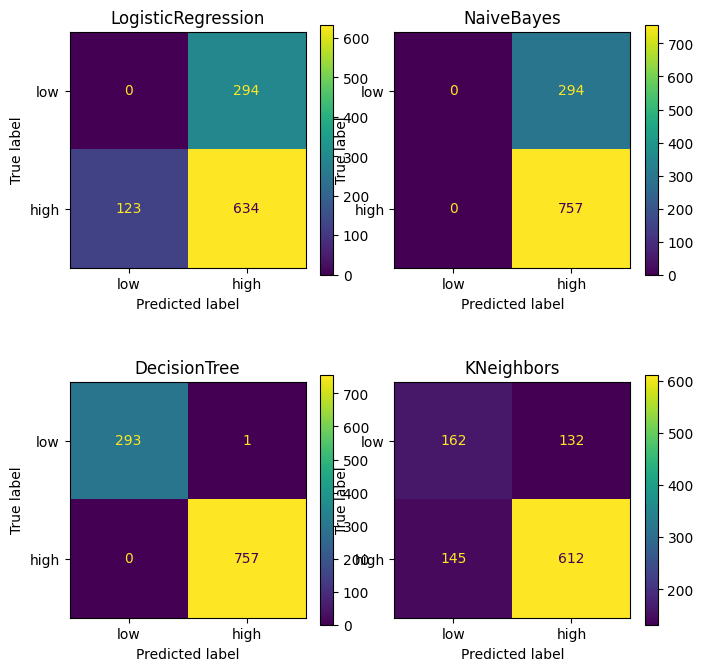

In [105]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Визуализация матриц
_, ax = plt.subplots(int(len(best_estimators) / 2), 2, figsize=(8, 6), sharex=False, sharey=False)
for index, key in enumerate(best_estimators.keys()):
    y_pred = best_estimators[key].predict(X_test_close)
    c_matrix = confusion_matrix(y_test_close, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=["low", "high"]).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

#### **Сделаем выводы относительно матрицы неточностей:**
1. Logistic Regression
* True Positives (TP): 634 (правильные предсказания для high)
* True Negatives (TN): 0 (не было правильных предсказаний для low)
* False Positives (FP): 294 (high предсказано, но на самом деле low)
* False Negatives (FN): 123 (low предсказано, но на самом деле high)

Вывод: Модель показывает высокую точность для прогноза high, но полностью игнорирует класс low. Это может вызвать серьезные проблемы, так как неверные прогнозы могут привести к значительным финансовым потерям.

2. Naive Bayes
* TP: 757 (правильные предсказания для high)
* TN: 0
* FP: 294
* FN: 0

Вывод: Модель предсказывает только high с высокой точностью, но также не распознает класс low. Это делает модель ненадежной в контексте предсказания как низких, так и высоких цен.

3. Decision Tree
* TP: 757
* TN: 293
* FP: 1
* FN: 0

Вывод: Модель хорошо справляется с предсказаниями для high, при этом включает небольшое количество неверных предсказаний для low (один FP). Справляется лучше в контексте выявления low цен, но все еще не идеально, так как не распознает FN.

4. KNeighbors
* TP: 612
* TN: 145
* FP: 132
* FN: 162

Вывод: Эта модель наиболее сбалансирована из всех представленных, показывая разумную точность для обоих классов. Она делает больше ошибок, но также учит и предсказывает low с некоторой эффективностью.

#### Точность, полнота, верность (аккуратность), F-мера:

In [106]:
class_metrics = pd.DataFrame.from_dict(param_grid, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

#### **Выводы:**
1. Decision Tree (Решающие деревья)
* Precision (Точность):
Высокий уровень как на обучающем (0.99992), так и на тестовом (0.99868) наборах данных.
* Recall (Полнота):
Идеальный результат на обучающем наборе (1.00000), с незначительным падением на тесте (0.99865).
* Accuracy (Точность):
Очень высокая: 0.99833 на обучающем и 0.999049 на тестовом наборах.
* F1 Score:
Высокий на обоих наборах (0.998824 для тестового).

Вывод: Деревья решений демонстрируют наилучшие результаты по всем метрикам. Они хорошо справляются как с обучающими, так и с тестовыми данными, и, вероятно, являются наилучшим выбором.

2. K-Neighbors (Метод ближайших соседей)
* Precision:
Низкая точность как на обучающем (0.833878), так и на тестовом (0.822581) наборах.
* Recall:
Высокая полнота на обучающем (0.856855), но значительно ниже на тестовом (0.808454).
* Accuracy:
Умеренные результаты: 0.777619 на обучающем и 0.736441 на тестовом.
* F1 Score:
Умеренная производительность (0.815456 на тестовом).

Вывод: Метод ближайших соседей показывает средние результаты. Хотя он имеет приемлемую полноту, точность значительно ниже, чем у деревьев решений.

3. Naive Bayes (Наивный байесовский классификатор)
* Precision:
Низкая точность (0.708571 на обучающем, 0.720266 на тестовом).
* Recall:
Полнота идеально на обучающем (1.00000), но это может указывать на переобучение.
* Accuracy:
Точность на уровне 0.708571 на обучающем и 0.720266 на тестовом — значительно ниже, чем у лучших моделей.
* F1 Score:
Умеренные результаты (0.837389 на тестовом).

Вывод: Наивный байесовский классификатор показывает проблемы с точностью, несмотря на хорошую полноту, что может указывать на его пригодность для задач, где много классов.

4. Logistic Regression (Логистическая регрессия)
* Precision:
Низкая точность (0.677130 на обучающем и 0.683190 на тестовом).
* Recall:
Полнота также ниже (0.862567 на тестовом).
* Accuracy:
Совсем низкие значения: 0.611190 на обучающем и 0.603235 на тестовом.
* F1 Score:
Низкие значения (0.752522 на тестовом).

Вывод: Логистическая регрессия демонстрирует наихудшие показатели по всем метрикам, что ставит под сомнение её применимость для данной задачи.
Лучшая модель: Деревья решений являются наиболее эффективной моделью.

#### ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса:

In [107]:
class_metrics = pd.DataFrame.from_dict(param_grid, "index")[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]
class_metrics.sort_values(by="ROC_AUC_test", ascending=False).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

#### **Выводы:**
1. Decision Tree (Решающие деревья)
* Accuracy (Точность): 0.999049
* F1 Score: 0.999340
* ROC AUC: 0.998295
* Cohen's Kappa: 0.997636
* MCC (Matthews Correlation Coefficient): 0.997639

Вывод: Деревья решений показывают наилучшие результаты по всем метрикам. Высокие значения точности, F1 Score и ROC AUC указывают на то, что модель хорошо справляется как с классификацией, так и с предсказанием вероятностей. Это делает её наиболее подходящей для задачи прогнозирования.

2. K-Neighbors (Метод ближайших соседей)
* Accuracy: 0.736441
* F1 Score: 0.815456
* ROC AUC: 0.769925
* Cohen's Kappa: 0.354679
* MCC: 0.354842

Вывод: Метод ближайших соседей демонстрирует средние результаты. Хотя F1 Score и ROC AUC указывают на относительно приемлемую степень точности, это всё же значительно уступает показателям деревьев решений. Учитывая цель, K-Neighbors может быть менее эффективным выбором.

3. Naive Bayes (Наивный байесовский классификатор)
* Accuracy: 0.720266
* F1 Score: 0.837389
* ROC AUC: 0.711442
* Cohen's Kappa: 0.000000
* MCC: 0.000000

Вывод: Наивный байесовский классификатор показывает также средние результаты, но его Cohen's Kappa и MCC ровны нулю. Это свидетельствует о том, что модель может плохо предсказывать тренды. Следовательно, её применение может быть ограниченным.

4. Logistic Regression (Логистическая регрессия)
* Accuracy: 0.603235
* F1 Score: 0.752522
* ROC AUC: 0.466647
* Cohen's Kappa: -0.197637
* MCC: -0.226884

Вывод: Логистическая регрессия показывает наихудшие результаты среди всех моделей. Низкие значения точности и ROC AUC указывают на ненадежность этой модели для прогнозирования цен акций, что делает её наименее подходящим вариантом для текущей бизнес-цели.

На основе проведенного анализа, Decision Tree является наилучшим выбором для построения модели прогнозирования цены акций. Она демонстрирует высокую производительность по всем ключевым метрикам, что делает её наиболее надежной и эффективной для предсказания цен закрытия. 

In [108]:
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'DecisionTree'

Визуализация ROC-кривой

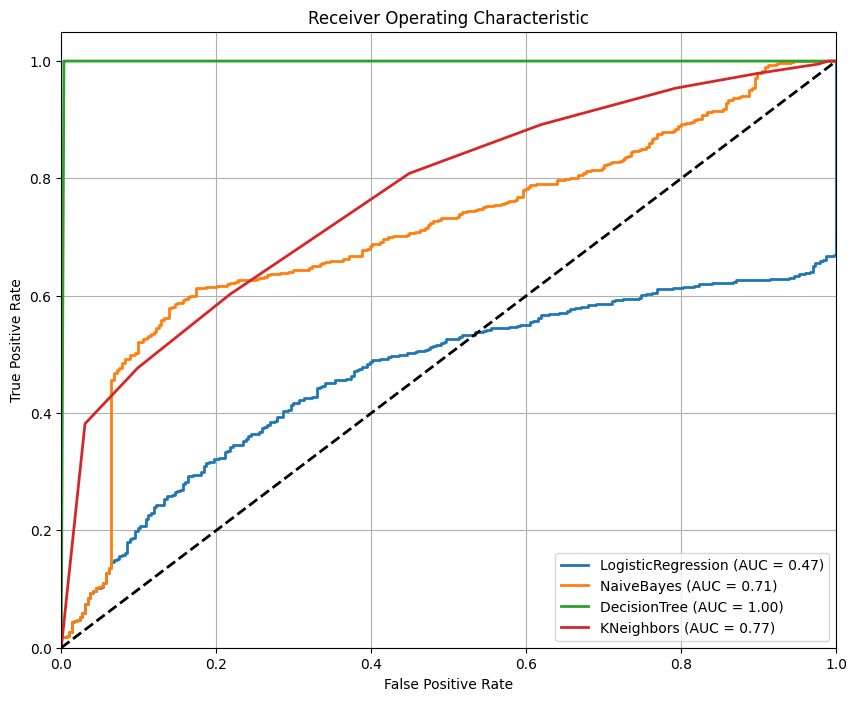

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

# Инициализация словаря для хранения результатов
results = {}

# После подбора модели
for model_name in best_estimators.keys():
    # Получаем вероятности для положительного класса
    y_scores = best_estimators[model_name].predict_proba(X_test_close)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_close, y_scores)
    roc_auc = auc(fpr, tpr)

    # Сохраняем полученные значения в словаре results
    results[model_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

# Визуализация ROC-кривой
plt.figure(figsize=(10, 8))
for model_name, metrics in results.items():
    plt.plot(metrics['fpr'], metrics['tpr'], lw=2, label=f'{model_name} (AUC = {metrics["roc_auc"]:.2f})')

# Диагональная линия глухого классификатора
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

ROC (Receiver Operating Characteristic) кривая — это график, используемый для оценки производительности классификаторов. Она отображает соотношение между двумя показателями:

True Positive Rate (TPR), также известная как чувствительность или полнота — доля верных положительных результатов среди всех положительных примеров.
False Positive Rate (FPR) — доля ложных положительных результатов среди всех отрицательных примеров.
ROC-кривая и AUC
ROC-кривая строится путем отображения TPR против FPR при разных порогах классификации. Площадь под ROC-кривой (AUC - Area Under the Curve) служит одной из основных метрик для оценки качества классификатора:

AUC = 1: Модель идеально классифицирует все примеры.
AUC = 0.5: Модель не лучше случайного угадывания.
AUC < 0.5: Модель показывает худшие результаты, чем случайный угадыватель.

**Анализ получившейся ROC-кривой:**
* Decision Tree (зеленая линия): AUC равен 1, что указывает на отличную производительность модели. Она идеально разделяет положительные и отрицательные классы.
* KNeighbors (синяя линия): AUC равен 0.77. Эта модель показывает хорошую производительность, но не так идеальна, как дерево решений.
* Naive Bayes (оранжевая линия): AUC равен 0.71. Модель демонстрирует средние результаты, но имеет значительные недостатки по сравнению с деревом решений.
* Logistic Regression (красная линия): AUC равен 0.47, что говорит о том, что модель практически неэффективна и хуже случайного классификатора.

**Общий вывод**
Модель дерева решений выделяется на фоне других, обеспечивая высокую точность. Это делает её наиболее предпочтительным вариантом для бизнес-прогнозирования. Остальные модели показывают более скромные результаты и могут быть менее надежными.